In [1]:
# %load general_load.py
#!/usr/bin/env python3

# Imports
import csv
import math
import os, os.path
import io
import sys
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from IPython.display import display

%matplotlib inline
sb.set()

def goldilocks_temp(t):
    if t < 273:
        return -1;
    elif t > 373:
        return 1;
    else:
        return 0

csv_filename = "./Data/exoplanetarchive/candidates-20190613-TIDIED.csv"
longnames = {}
with open(csv_filename, 'r') as f:
    lines = f.readlines()
    for line in lines[8:23]:
        varname, longname = line.strip().split(':')
        varname = varname[9:].strip()
        longname = longname.replace(',', '').strip()
        #print(varname, longname)
        longnames[varname] = longname
        
dataset = pd.read_csv(csv_filename, header = 24)

goldilocks_dataset = dataset.drop(['kepid',
                                   'koi_period',
                                   'koi_period_err1',
                                   'koi_prad_err1',
                                   #'koi_insol',
                                   'koi_insol_err1', 
                                   'koi_steff',
                                   'koi_steff_err1',
                                   'koi_slogg',
                                   'koi_slogg_err1',
                                   #'koi_srad',
                                   'koi_srad_err1'],
                                  axis=1).copy()
goldilocks_dataset.head()

goldilocks_dataset["gold_temp"] = list(map(goldilocks_temp, goldilocks_dataset["koi_teq"]))
goldilocks_dataset = goldilocks_dataset.dropna()

goldX = goldilocks_dataset.drop(["kepoi_name","koi_teq","gold_temp"], axis=1)
goldY = goldilocks_dataset['gold_temp']

goldX.columns = [longnames[x] for x in goldX.columns]


## Jupyter loads

In [2]:
from astropy.io import fits
from astropy.wcs import WCS

## Obtaining The Full Frame Image

In [3]:
# For the purposes of this tutorial, we just know the MAST URL location of the file we want to examine.
fits_file = "https://archive.stsci.edu/missions/tess/ffi/s0001/2018/206/4-2/tess2018206192942-s0001-4-2-0120-s_ffic.fits"

## Understanding The FFI FITS File Structure

In [4]:
fits.info(fits_file)

Filename: /home/jdowzell/.astropy/cache/download/py3/a2387fb351da2473071afffde7bf341c
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  CAMERA.CCD 4.2 cal    1 ImageHDU       183   (2136, 2078)   float32   
  2  CAMERA.CCD 4.2 uncert    1 ImageHDU       183   (2136, 2078)   float32   


## Reading the WCS and Calibrated Image

In [5]:
with fits.open(fits_file, mode = "readonly") as hdulist:
    wcs_info = WCS(hdulist[1].header)
    cal_image = hdulist[1].data
    header = hdulist[1].header

In [6]:
# Use the header to determine the mid-point of the exposure time for this FFI.
mid_time = (header['TSTOP'] + header['TSTART']) / 2

## Display the Image

(2078, 2136)

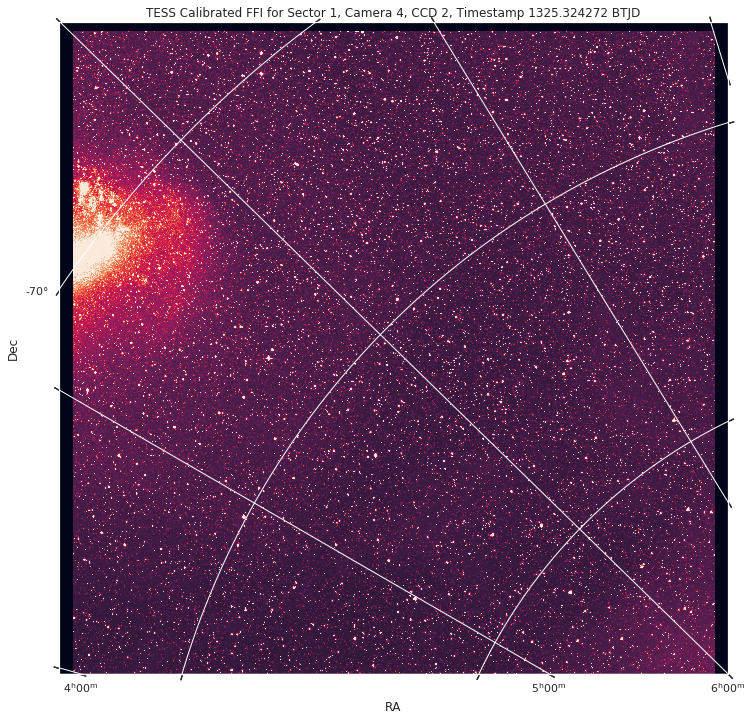

In [7]:
plt.figure(figsize = (12,12))

plt.subplot(111, projection = wcs_info)
plt.imshow(cal_image, vmin = np.percentile(cal_image,4),vmax = np.percentile(cal_image, 98),origin = "lower")
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title("TESS Calibrated FFI for Sector 1, Camera 4, CCD 2, Timestamp %f BTJD" % mid_time)

cal_image.shape

In [ ]:
# Not shown above - I had to run
# "pip install --upgrade astropy wcsaxes"
# to get it to work (was running astropy 1.1.2, needed 3.3.2)